# Mini-Project for Fundamentals of Machine Learning Course


In this study, facial expression recognition was performed on the face images from the Facial Expression Recognition Challenge (FER2013) dataset.

One motivation for representation learning is that learning algorithms can design features more effectively and efficiently than humans can. However, this challenge does not explicitly require entries to use representation learning. The dataset, assembled from the internet, is designed for facial expression classification.

The data consists of grayscale images of faces, each measuring 48x48 pixels. The faces have been automatically aligned to be roughly centered and occupy a similar area within each image. The task is to categorize each face based on the emotion expressed, assigning it to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The dataset contains a total of 35,887 examples.


## 1. Prerequisite

This section provides some basic steps for accessing and visualizing the dataset.


In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import warnings
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    ConfusionMatrixDisplay,
)
from tqdm import tqdm
from skimage import exposure, img_as_float

warnings.filterwarnings("ignore")
plt.style.use("ggplot")

In [3]:
def parse_data(data: pd.DataFrame) -> tuple[np.ndarray, ...]:
    """
    Reads input dataframe then return arrays of images and labels
    """
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data["emotion"])))

    for i, row in tqdm(enumerate(data.index)):
        image = np.fromstring(data.loc[row, "pixels"], dtype=int, sep=" ")
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

In [4]:
def show_img(images: np.ndarray, labels: np.ndarray) -> None:
    """
    Visualize images and labels respectively
    """
    _, axarr = plt.subplots(nrows=2, ncols=5, figsize=(18, 9))
    axarr = axarr.flatten()
    for idx, label in enumerate(labels[:10]):
        axarr[idx].imshow(images[idx], cmap="gray")
        axarr[idx].set_xticks([])
        axarr[idx].set_yticks([])
        axarr[idx].set_title("Label:{}".format(label))

In [5]:
## load dataset here
df = pd.read_csv("/kaggle/input/dataset-projectml-fer2013/icml_face_data.csv")
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


The `emotion` column contains a numeric code ranging from 0 to 6, inclusive, for the emotion expressed by the image. The "pixels" column contains a string surrounded in quotes for each image.


In [6]:
## parsing data here
images, labels = parse_data(df)

35887it [00:03, 9793.85it/s] 


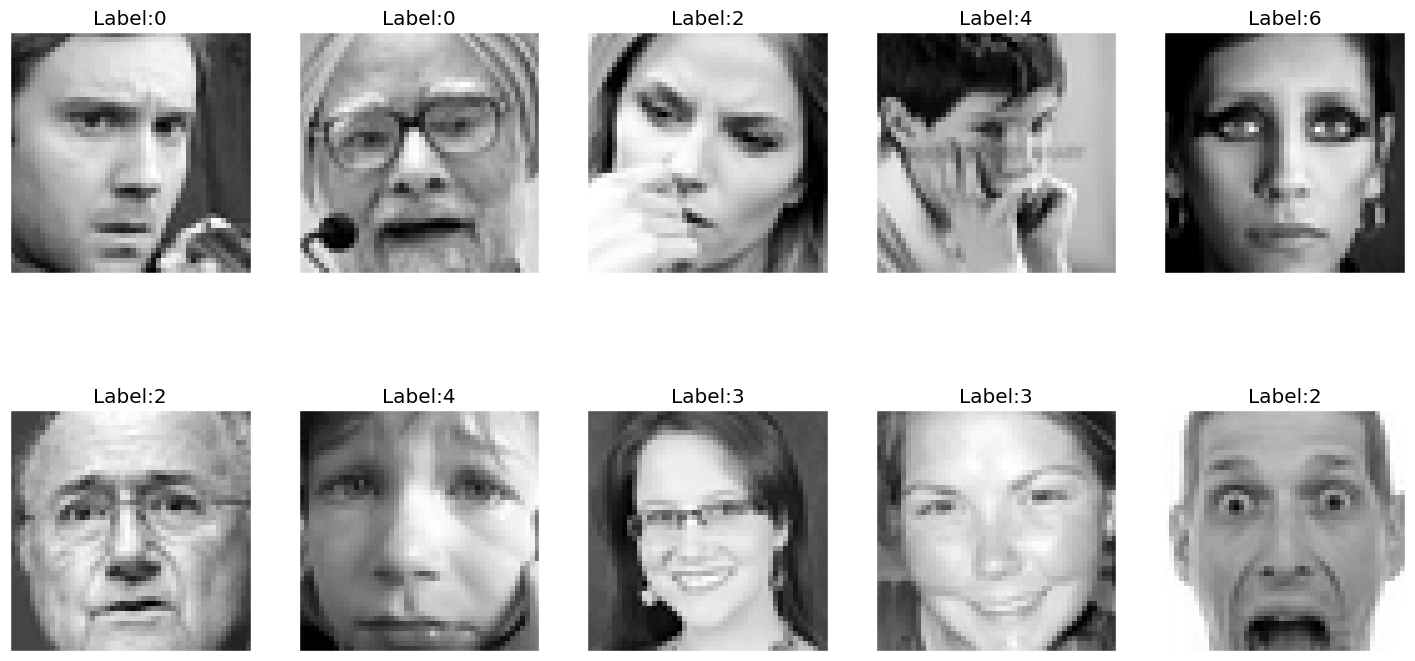

In [7]:
## showing images here
show_img(images, labels)

## 2'. Prepocessing original images

### Normalizing Image


In [8]:
raw_images = images.copy()
normalized_images = images / 255.0

### Histogram Equalization


In [9]:
def plot_img_and_hist(
    image: np.ndarray[float], axes: mpl.axes.Axes, bins=256
) -> tuple[mpl.axes.Axes, ...]:
    """Plot an image along with its histogram and cumulative histogram."""
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype="step", color="black")
    ax_hist.ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))
    ax_hist.set_xlabel("Pixel intensity")
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, "r")
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf

Plotting an image and its histogram


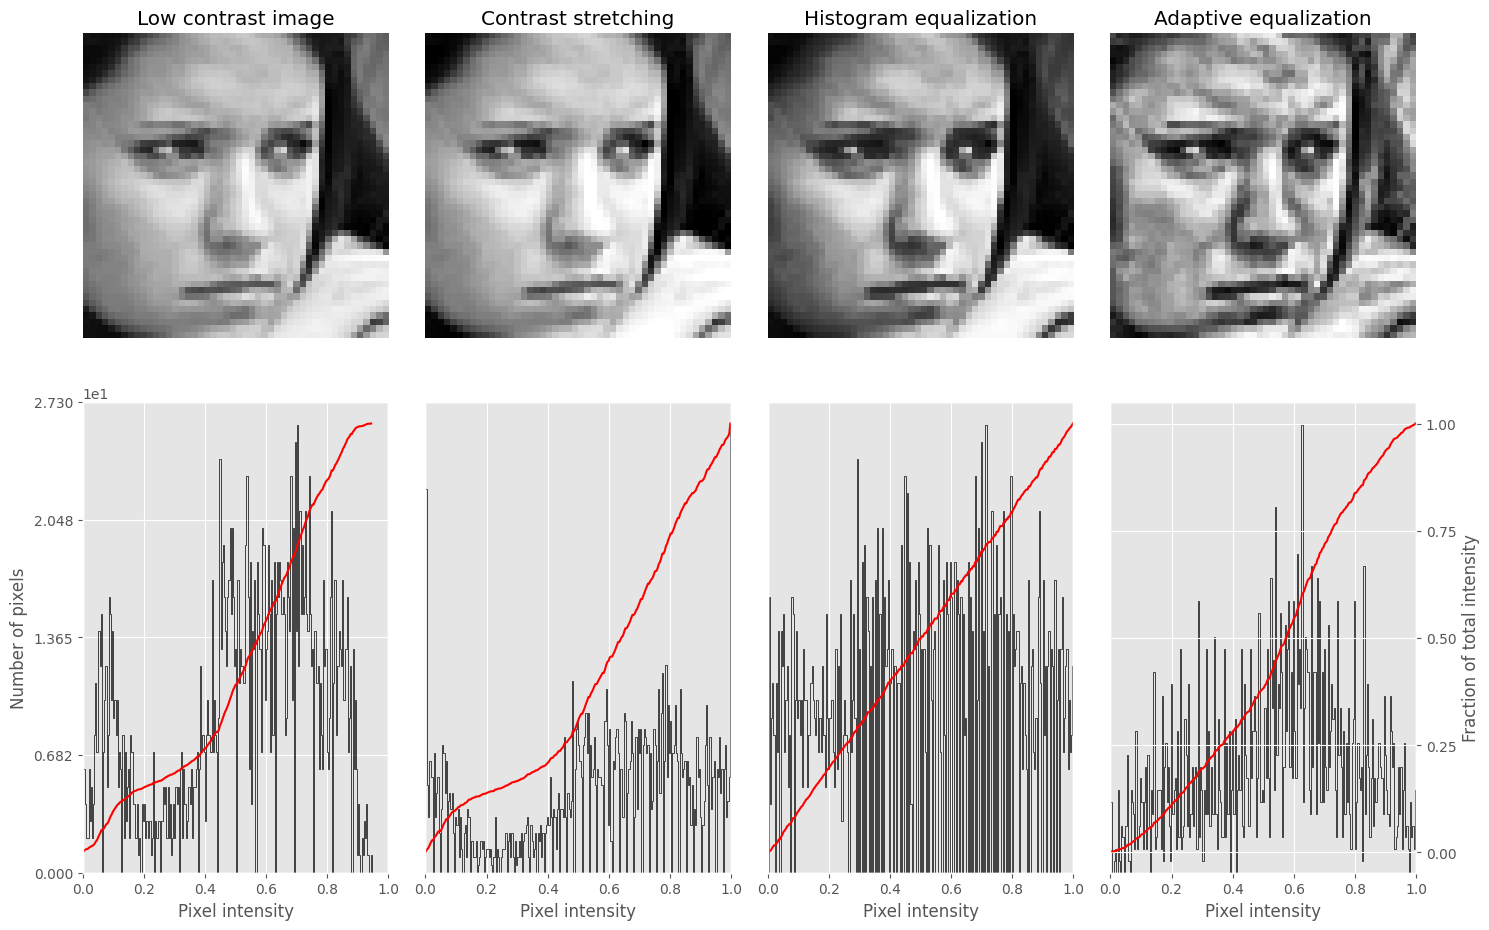

In [ ]:
# Load an example image
img = normalized_images[-1]

# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# Display results
fig = plt.figure(figsize=(15, 10))
axes = np.zeros((2, 4), dtype=object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1 + i, sharex=axes[0, 0], sharey=axes[0, 0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5 + i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title("Low contrast image")

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel("Number of pixels")
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title("Contrast stretching")

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title("Histogram equalization")

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title("Adaptive equalization")

ax_cdf.set_ylabel("Fraction of total intensity")
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

In [11]:
# Apply adaptive histogram equalization
adapteq_images = np.array(
    [
        exposure.equalize_adapthist(img, clip_limit=0.03)
        for img in tqdm(normalized_images)
    ]
)

100%|██████████| 35887/35887 [02:18<00:00, 259.38it/s]


## 2. Principle Component Analysis

Unsupervised learning can be further categorized into two main tasks: data transformation and clustering. In this study, we will focus on data transformation using unsupervised learning techniques. These techniques aim to modify the data to make it easier for computers and humans to analyze and understand.

One of the most common applications of unsupervised data transformation is dimensionality reduction. This process reduces the number of features (dimensions) in the data. When the data has a high number of features, it can be computationally expensive and difficult to analyze. Dimensionality reduction techniques help to overcome these challenges.

Principal Component Analysis (PCA) is a popular technique for dimensionality reduction. It transforms the data into a new set of features called principal components (PCs). These PCs are ordered by their importance, capturing the most significant variations in the data. By selecting a subset of the most informative PCs, we can achieve a significant reduction in data size while preserving the essential information for analysis.

Question 1: Can you visualize the data projected onto two principal components? (2 points)


In [12]:
# Reshape images to 2D-array
images = adapteq_images.reshape(labels.shape[0], -1)

In [13]:
# Apply PCA with 2 principal components
pca_2_components = PCA(n_components=2)
pca_images = pca_2_components.fit_transform(images)
pca_images.shape

(35887, 2)

In [14]:
def reconstructing_image(image: np.ndarray[float], pca: PCA) -> np.ndarray[int]:
    """
    Reconstructs an image using the inverse transform of a PCA model.

    Args:
        image (np.ndarray[float]): The input image as a 1D numpy array.
        pca (PCA): An instance of the PCA class from sklearn.decomposition.

    Returns:
        np.ndarray[int]: The reconstructed image as a 2D numpy array.

    Raises:
        TypeError: If pca is not an instance of sklearn.decomposition.PCA.

    """
    # Compute the inverse transform of the input image
    reconstructed_images = pca.inverse_transform(image)

    # Rescale the reconstructed image to the range [0, 255] and convert to uint8
    reconstructed_images = (reconstructed_images * 255).astype(np.uint8)

    # Reshape the reconstructed image to 2D array
    reconstructed_images = reconstructed_images.reshape(48, 48)
    return reconstructed_images

In [15]:
def plot_compare_pca_images(
    raw: np.ndarray[int],
    transformed: np.ndarray[float],
    labels: np.ndarray,
    pca: PCA,
    n_images: int = 4,
) -> None:
    """
    Plot a comparison of raw and transformed images.

    Args:
        raw (np.ndarray[int]): Array of raw images.
        transformed (np.ndarray[float]): Array of transformed images.
        labels (np.ndarray): Array of labels corresponding to the images.
        pca (PCA): PCA object used for image reconstruction.
        n_images (int): Number of images to plot. Default is 4.
    """
    # Create figure with subplots
    _, axes = plt.subplots(nrows=2, ncols=n_images, figsize=(2 * n_images, 5))

    # Iterate over the labels
    for idx, label in enumerate(labels):
        # Break the loop if all images are plotted
        if idx >= n_images:
            break

        # Generate random index for a label
        idx_random = np.random.randint(0, len(labels))

        # Plot raw image
        axes[0][idx].imshow(raw[idx_random], cmap="gray")
        axes[0][idx].set_xticks([])
        axes[0][idx].set_yticks([])
        axes[0][idx].set_title(f"Raw|Label:{label}")

        # Plot transformed image
        axes[1][idx].imshow(
            reconstructing_image(transformed[idx_random], pca=pca), cmap="gray"
        )
        axes[1][idx].set_xticks([])
        axes[1][idx].set_yticks([])
        axes[1][idx].set_title(f"Transformed|Label:{label}")

    # Adjust the layout and show the plot
    plt.tight_layout()
    plt.show()

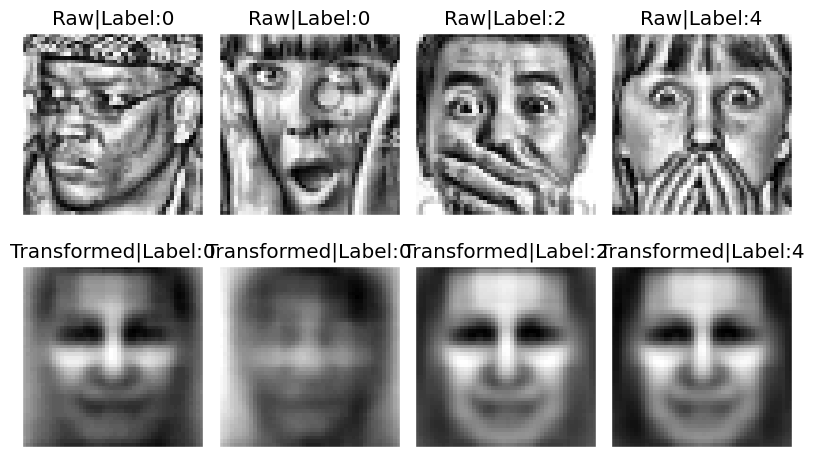

In [16]:
plot_compare_pca_images(adapteq_images, pca_images, labels, pca_2_components)

Question 2: How to determine the optimal number of principal components using `pca.explained_variance_`? Explain your selection process. (2 points)


In [17]:
pca_full = PCA()
pca_full.fit(images)

PCA()

In [18]:
## determine the optimal number of PCs here
explained_variance_ratio = pca_full.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
_ = [
    print(
        f"{np.min(np.where(cumulative_explained_variance >= percent)[0])} PCs explain {percent}% of the variance"
    )
    for percent in [0.9, 0.95, 0.98, 0.99]
]

458 PCs explain 0.9% of the variance
785 PCs explain 0.95% of the variance
1254 PCs explain 0.98% of the variance
1571 PCs explain 0.99% of the variance


Plot the cumulative explained variance by number of principal components


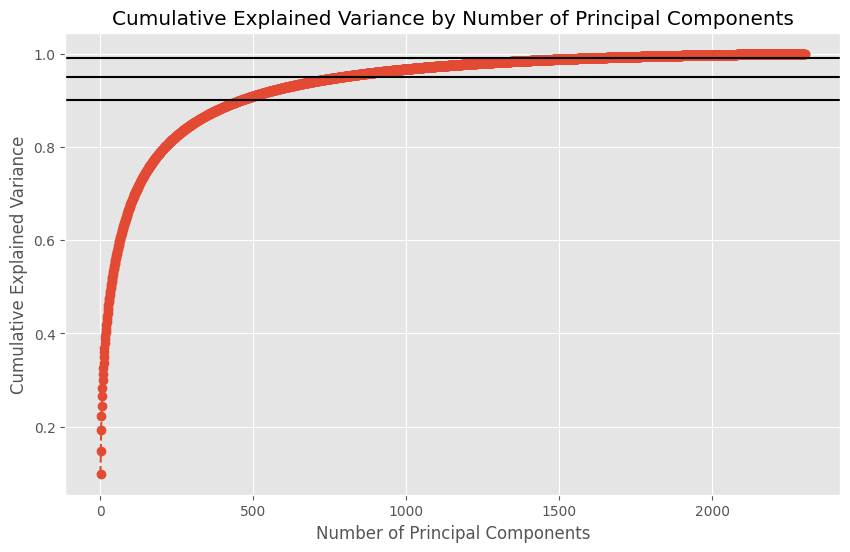

In [19]:
plt.figure(figsize=(10, 6))

# Plot the cumulative explained variance against the number of principal components
plt.plot(
    range(1, len(cumulative_explained_variance) + 1),
    cumulative_explained_variance,
    marker="o",  # marker style
    linestyle="--",  # line style
)

plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance by Number of Principal Components")
[plt.axhline(y=y, color="black") for y in [0.9, 0.95, 0.99]]
plt.grid(True)
plt.show()

Plot the difference in cumulative explained variance by number of principal components


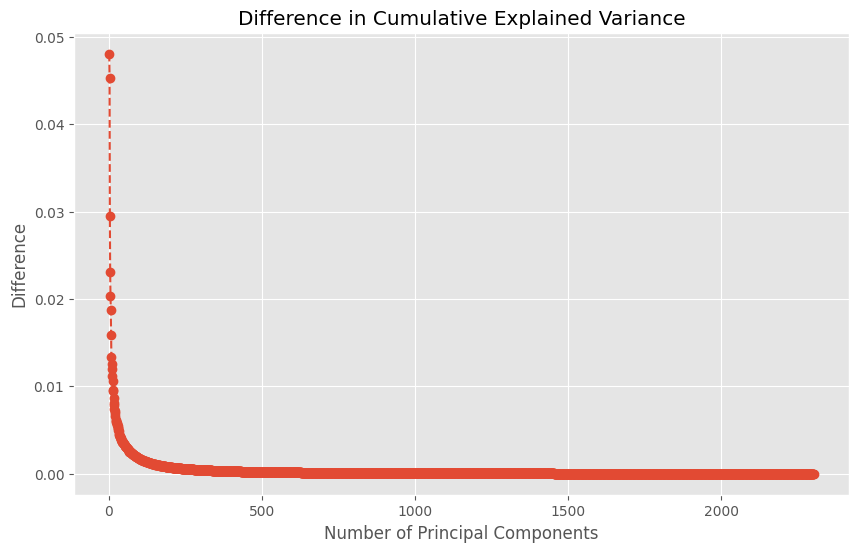

In [20]:
plt.figure(figsize=(10, 6))

# Plot the difference in cumulative explained variance against the number of principal components
plt.plot(
    range(1, len(cumulative_explained_variance)),
    np.diff(cumulative_explained_variance),
    marker="o",  # marker style
    linestyle="--",  # line style
)

plt.xlabel("Number of Principal Components")
plt.ylabel("Difference")
plt.title("Difference in Cumulative Explained Variance")
plt.grid(True)
plt.show()

Dựa vào 2 hình vẽ ở trên

1. Số lượng thông tin của dữ liệu dựa trên số PCs
2. Hiệu của hai giá trị thông tin liền kề nhau

và mục đích là huấn luyện được mô hình có khả năng dự đoán tốt nhất.

Suy ra, ta sẽ chọn giữ lại nhiều thông tin nhất có thể của một bức ảnh, nên ta sẽ chọn giữ lại 1571 PCs (tương ứng với 99% thông tin bức ảnh). Từ đó, ta loại bỏ đi 733 (48x48 - 1571) PCs chứa lượng thông tin thấp nhất


In [21]:
origin_data = adapteq_images.reshape(labels.shape[0], -1)
transformed_data = PCA(n_components=0.99).fit_transform(images)

## 3. Image Classification

The classification task will compare the performance using both:

- Original data: The data before applying PCA.
- Transformed data: The data projected onto the optimal number of principal components identified earlier. Utilize the **optimal number of principal components** identified in the previous question.

Compare the performance of **4** different classification algorithms (3 machine learning and 1 MLP models) in both formats above. (4 points)

Perform hyperparameter tuning using `GridSearchCV` for each classification method. (1 point)

Inspiration: Draw inspiration from the example provided in the scikit-learn documentation: https://scikit-learn.org/dev/auto_examples/datasets/plot_iris_dataset.html



### Spliting Data to Train and Test


In [22]:
origin_X_train, origin_X_test, origin_y_train, origin_y_test = train_test_split(
    origin_data, labels, test_size=0.2, random_state=42
)

transformed_X_train, transformed_X_test, transformed_y_train, transformed_y_test = (
    train_test_split(transformed_data, labels, test_size=0.2, random_state=42)
)

origin_y_train = origin_y_train.reshape(-1, 1)
origin_y_test = origin_y_test.reshape(-1, 1)
transformed_y_train = transformed_y_train.reshape(-1, 1)
transformed_y_test = transformed_y_test.reshape(-1, 1)

In [23]:
_ = [
    print(f"{key}: {value.shape}")
    for key, value in {
        "Shape of Original training data": origin_X_train,
        "Shape of Original testing data": origin_X_test,
        "Shape of Original training target": origin_y_train,
        "Shape of Original testing target": origin_y_test,
        "Shape of Transformed training data": transformed_X_train,
        "Shape of Transformed testing data": transformed_X_test,
        "Shape of Transformed training target": transformed_y_train,
        "Shape of Transformed testing target": transformed_y_test,
    }.items()
]

Shape of Original training data: (28709, 2304)
Shape of Original testing data: (7178, 2304)
Shape of Original training target: (28709, 1)
Shape of Original testing target: (7178, 1)
Shape of Transformed training data: (28709, 1572)
Shape of Transformed testing data: (7178, 1572)
Shape of Transformed training target: (28709, 1)
Shape of Transformed testing target: (7178, 1)


### 3.1. SVM
---


In [24]:
pass

### 3.2. Random Forest
---


In [25]:
pass

### 3.3. Logistic Regression
---


In [26]:
from sklearn.metrics import f1_score, make_scorer

In [ ]:
def build_model_logistic_regression(X_train, y_train):

    # Define the parameter grid
    logreg = LogisticRegression(solver='liblinear')

    # Define the parameter grid
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
        'penalty': ['l2', 'l1']  # Regularization type (note: 'saga' solver supports both)
    }

    # Define the scorer for GridSearchCV
    scorer = make_scorer(f1_score, average='macro')

    # Perform grid search
    grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, scoring=scorer, cv=3)
    grid_search.fit(X_train, y_train)

    # Get the best parameters
    best_params = grid_search.best_params_
    print(f"Best parameters found: {best_params}")

    # Train the model with the best parameters
    best_model = grid_search.best_estimator_

    return best_model


Training with original data

In [ ]:
# Get the best model of Logistic
model = build_model_logistic_regression(origin_X_train, origin_y_train)

# Make predictions on the test set
predictions_origin = model.predict(origin_X_test)

# Evaluate the model
# Since it's multi-class, we use average='macro' to account for class imbalance
print("Accuracy: ", accuracy_score(origin_y_test, predictions_origin))
print("Precision: ", precision_score(origin_y_test , predictions_origin, average = 'micro'))
print("Recall: ", recall_score(origin_y_test , predictions_origin, average = 'micro'))
print("F1: ", f1_score(origin_y_test , predictions_origin, average = 'micro'))

Training with transform data

In [ ]:
# Get the best model of Logistic
model = build_model_logistic_regression(transformed_X_train, transformed_y_train)

# Make predictions on the test set
predictions_transformed = model.predict(transformed_X_test)

# Evaluate the model
# Since it's multi-class, we use average='macro' to account for class imbalance
print("Accuracy: ", accuracy_score(transformed_y_test, predictions_transformed))
print("Precision: ", precision_score(transformed_y_test , predictions_transformed, average = 'micro'))
print("Recall: ", recall_score(transformed_y_test , predictions_transformed, average = 'micro'))
print("F1: ", f1_score(transformed_y_test , predictions_transformed, average = 'micro'))

### 3.4. MLP
---


In [ ]:
pass

## 4. Evaluating Classification Performance

Compare the performance of the different classification models using various metrics: accuracy, precision, recall, and F1-score.
Based on the evaluation metrics, explain which model performs best and why. Identify the emotion category where the model makes the most accurate and most errors. (1 point)


In [ ]:
## visualize the confusion matrices and classification reports here